In [ ]:
!pip install graphviz
from typing import Union, Tuple, List, Set, Callable
from graphviz import Digraph
import math


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        #dot.node(name=str(id(n)), label = "{ data %.4f | grad}" % (n.data), shape='record')

        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [ ]:
class Value():
    def __init__(self, data: Union[float, int], _children: Tuple["Value", ...]=(), _op: str="") -> None:
        """Initializes a scalar with its data."""
        self.data = float(data)
        self.grad = 0.0

        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None


    def __repr__(self):
        """Returns a printable representation of the given Value object."""
        return f"Value(data={self.data})"


    def __add__(self, other: Union["Value", float, int]):
        """Adds two Value objects (or a Value object with a Python int/float). e.g., self + other"""
        _other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + _other.data, _children = (self, _other), _op = "+")

        def _backward() -> None:
            """Going backwards through the computation graph, calculates the deriviates of the final node w.r.t. self and other (for this addition operation).
            Via the chain rule, self.grad = (the local derivative d(out)/d(self)) * (the gradient of out w.r.t. the final node (which was already calculated since we are going backward)).
            Via the chain rule, _other.grad = (the local derivative d(out)/d(_other)) * (the gradient of out w.r.t. the final node).
            The reason it is `+=` (instead of just `=`) is because each `self` and `_other` object could have been used for calculating many `out` objects, and so you need to add those gradients together.""" 
            self.grad += (1 * out.grad)     # local derivative for addition: d(out)/d(self) = 1
            _other.grad += (1 * out.grad)   # local derivative for addition: d(out)/d(_other) = 1
        out._backward = _backward

        return out

    def __sub__(self, other):
        pass


    def __mul__(self, other: Union["Value", float, int]):
        """Multiplies two Value objects (or a Value object with a Python int/float). e.g., self * other"""
        _other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * _other.data, _children = (self, _other), _op = "*")

        def _backward() -> None:
            """Going backwards through the computation graph, calculates the deriviates of the final node w.r.t. self and other (for this multiplication operation).""" 
            self.grad += (_other.data * out.grad)   # local derivative for multiplication: d(out)/d(self) = _other
            _other.grad += (self.data * out.grad)   # local derivative for multiplication: d(out)/d(_other) = self
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        tanh_x = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) 
        out = Value(tanh_x, _children = (self, ), _op = "tanh")

        def _backward() -> None:
            self.grad += (1 - tanh_x**2) * out.grad    # local derivative of tanh: d(out)/d(self) = 1 - tanh(selsf)^2
        out._backward = _backward

        return out

    def __radd__(self, other: Union["Value", float, int]):
        """Adds a Python int/float with a Value object. e.g., other + self

        Without this method, if a command were `a = 2 + Value(3)`, a TypeError would occur 
        because Python does not know what to do with 2.__add__(Value(3))."""
        return self + other


    def __rmul__(self, other: Union["Value", float, int]):
        """Multiplies a Python int/float with a Value object. e.g., other * self

        Without this method, if a command were `a = 2 * Value(3)`, a TypeError would occur 
        because Python does not know what to do with 2.__mul__(Value(3))."""
        return self * other



In [ ]:
a = Value(0.4)
b = Value(0.5)
c = a + b
d = 0.4 + c
e = d.tanh()


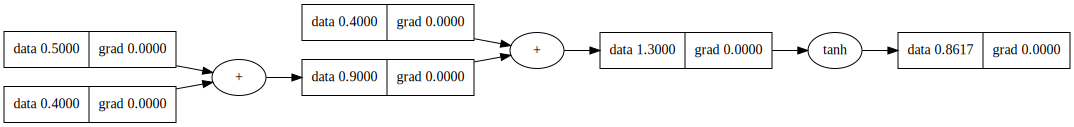

In [ ]:
draw_dot(e)

In [ ]:
e.grad = 1.0
e._backward()
d._backward()

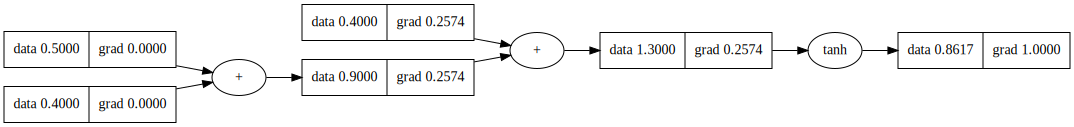

In [ ]:
draw_dot(e)